In [1]:
import os
import pandas as pd
import numpy as np
from zipline import run_algorithm
from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import AverageDollarVolume,CustomFactor, Returns
from zipline.api import (attach_pipeline, calendars, pipeline_output,
date_rules, time_rules, set_commission, set_slippage, record,
order_target_percent, get_open_orders, get_datetime, schedule_function)
import pandas_datareader as web

In [36]:
from zipline.data.bundles.core import load
os.environ["QUANDL_API_KEY"] = "CEu3xBT_6d_sfPsdv4tx"
bundle_data = load("quotemedia",os.environ, None)

In [27]:
num_longs = num_shorts = 50

In [28]:
class MomentumFactor(CustomFactor):
    inputs = [USEquityPricing.close, Returns(window_length=126)]
    window_length = 252
    def compute(self, today, assets, out, prices, returns):
        out[:] = ( (prices[-21] - prices[-252]) / prices[-252]
                  - (prices[-1] - prices[-21]) / prices[-21] )/np.nanstd(returns, axis=0)

In [29]:
def make_pipeline():
    momentum = MomentumFactor()
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(columns={
    "factor": momentum, "longs": momentum.top(num_longs),
    "shorts": momentum.bottom(num_shorts), "ranking": momentum.rank()},
    screen=dollar_volume.top(100)
    )

In [30]:
def before_trading_start(context, data):
    context.factor_data = pipeline_output("factor_pipeline")
def initialize(context):
    attach_pipeline(make_pipeline(),"factor_pipeline")
    schedule_function(rebalance,date_rules.week_start(),
    time_rules.market_open(), calendar=calendars.US_EQUITIES)

In [31]:
def rebalance(context,data):
    factor_data = context.factor_data
    record(factor_data=factor_data.ranking)
    assets = factor_data.index
    record(prices=data.current(assets,"price"))
    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    divest = set(context.portfolio.positions.keys()) - set(longs.union(shorts))
    exec_trades(data,assets=divest, target_percent=0)
    exec_trades(data,assets=longs,target_percent=1/num_longs)
    exec_trades(data,assets=shorts,target_percent=-1/num_shorts)

In [32]:
def exec_trades(data, assets, target_percent):
    for asset in assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset,target_percent)

In [40]:
start = pd.Timestamp("2021")
end = pd.Timestamp("2024")
perf = run_algorithm(start=start, end=end,
                     initialize=initialize,
                     before_trading_start=before_trading_start,
                     capital_base = 100000, bundle = "quotemedia")

/Users/npastori/miniforge3/envs/quant-stack/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/8y/y_xnbb8130dc6w17tlz0p5v80000gn/T/ipykernel_41593/1127586882.py:5: RuntimeWarning: invalid value encountered in divide
  out[:] = ( (prices[-21] - prices[-252]) / prices[-252]
/Users/npastori/miniforge3/envs/quant-stack/lib/python3.10/site-packages/zipline/utils/events.py:486: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  .view(np.int64)
/Users/npastori/miniforge3/envs/quant-stack/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/8y/y_xnbb8130dc6w17tlz0p5v80000gn/T/ipykernel_41593/1127586882.py:5: RuntimeWarning: invalid

In [41]:
perf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 753 entries, 2021-01-04 21:00:00+00:00 to 2023-12-29 21:00:00+00:00
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   period_open              753 non-null    datetime64[ns, UTC]
 1   period_close             753 non-null    datetime64[ns, UTC]
 2   ending_value             753 non-null    float64            
 3   capital_used             753 non-null    float64            
 4   positions                753 non-null    object             
 5   starting_exposure        753 non-null    float64            
 6   ending_exposure          753 non-null    float64            
 7   net_leverage             753 non-null    float64            
 8   transactions             753 non-null    object             
 9   pnl                      753 non-null    float64            
 10  longs_count              753 non-null    int64   

<Axes: title={'center': 'Cumulative Returns'}>

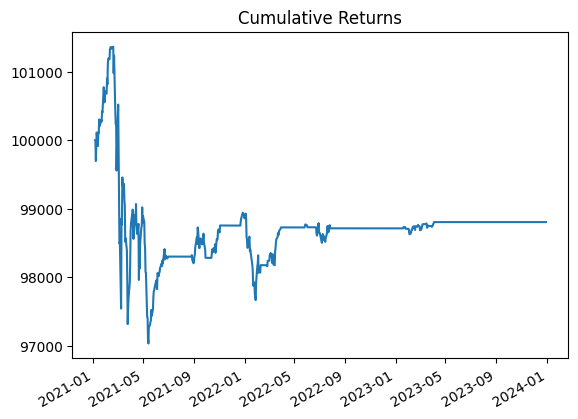

In [42]:
perf.portfolio_value.plot(title="Cumulative Returns")

<Axes: title={'center': 'Rolling Sharpe Ratio'}>

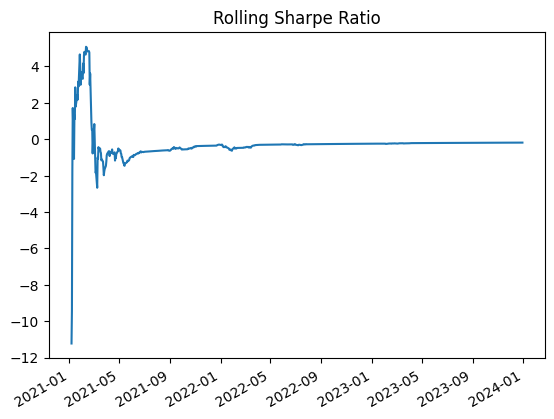

In [51]:
perf.sharpe.plot(title="Rolling Sharpe Ratio")

<Axes: title={'center': 'SPY Price'}, xlabel='DATE'>

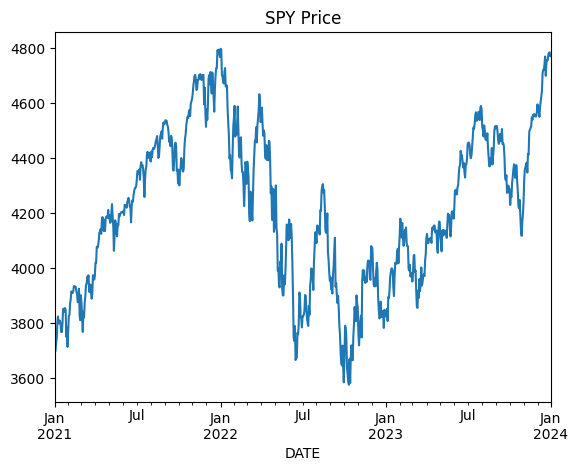

In [50]:
sp500 = web.DataReader('SP500', 'fred', start, end).SP500.ffill()
sp500.plot(title="SPY Price")

In [55]:
perf.ending_cash

2021-01-04 21:00:00+00:00    100000.000000
2021-01-05 21:00:00+00:00     88999.741650
2021-01-06 21:00:00+00:00     88999.741650
2021-01-07 21:00:00+00:00     88999.741650
2021-01-08 21:00:00+00:00     88999.741650
                                 ...      
2023-12-22 21:00:00+00:00     98805.236735
2023-12-26 21:00:00+00:00     98805.236735
2023-12-27 21:00:00+00:00     98805.236735
2023-12-28 21:00:00+00:00     98805.236735
2023-12-29 21:00:00+00:00     98805.236735
Name: ending_cash, Length: 753, dtype: float64